In [38]:
import tensorflow_hub as hub
import tensorflow.compat.v2 as tf
import numpy as np
import matplotlib.pyplot as plt
import ddsp
from tensorflow import keras
from IPython.display import Audio

def play(audio):
    return Audio(audio, rate=16000)

def output2hz(pitch_output):
  # Calibration constants
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

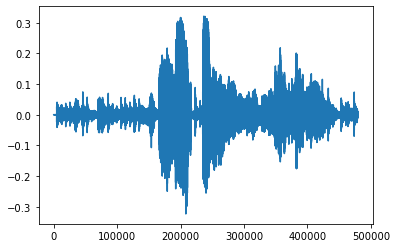

tf.Tensor(76.733345, shape=(), dtype=float32)


In [37]:
model = hub.load("https://tfhub.dev/google/spice/2")

audio_binary = tf.io.read_file('test.wav')
audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=16000*30)
audio = audio.numpy().reshape(-1,)
plt.plot(audio)
plt.show()

# Run model. One would use real singing as input, here we use the above
# waveform for testing.
input = tf.constant(audio)
model_output = model.signatures["serving_default"](input)
pitches = output2hz(model_output["pitch"])
uncertainties = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidences = 1.0 - uncertainties

some_pitch = pitches[2]

audio_feats = {'audio': audio, 'f0_hz': pitches, 'f0_confidence' : confidences}

audio_feats['loudness_db'] = ddsp.spectral_ops.compute_loudness(audio, sample_rate, frame_rate, n_fft)

print(output2hz(some_pitch))
play(audio)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A1 (InputLayer)                 [(None, 480000)]     0                                            
__________________________________________________________________________________________________
P1 (InputLayer)                 [(None, 938)]        0                                            
__________________________________________________________________________________________________
A2 (Dense)                      (None, 30)           14400030    A1[0][0]                         
__________________________________________________________________________________________________
P2 (Dense)                      (None, 30)           28170       P1[0][0]                         
____________________________________________________________________________________________

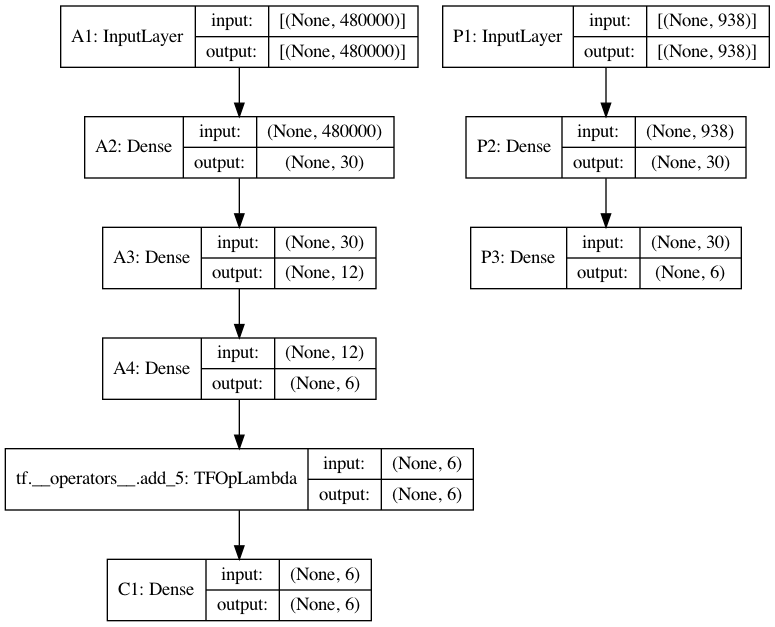

In [31]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from ddsp.spectral_ops import pad_or_trim_to_expected_length
from ddsp.training.encoders import ResnetSinusoidalEncoder


P1 = Input(shape=(938,),name='P1')
P2 = Dense(30, activation='relu',name='P2')(P1)
P3 = Dense(6, activation='relu',name='P3')(P2)

A1 = Input(shape=(480000,),name='A1')
A2 = Dense(30, activation='relu',name='A2')(A1)
A3 = Dense(12, activation='relu',name='A3')(A2)
A4 = Dense(6, activation='relu',name='A4')(A3)

C1 = Dense(6, activation='linear', name='C1')(A4+P3)

merged = Model(inputs=[P1,A1],outputs=[P3,C1])
merged.summary()
plot_model(merged,to_file='demo.png',show_shapes=True)